# 1.1 Import libraries 

In [2]:
import pandas as pd
from pandas_ml import ConfusionMatrix
import numpy as np
import random
import os
from math import log,sqrt
import math
from math import log
import re


import sklearn
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn import cross_validation
from sklearn import feature_selection

from sklearn.metrics import (confusion_matrix, f1_score, accuracy_score, precision_score,recall_score,
                             classification_report,log_loss)
from sklearn.metrics import mean_squared_error
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_validation import cross_val_score, cross_val_predict

# Algorithms
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,AdaBoostClassifier)
#from xgboost import XGBClassifier

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import AdaBoostClassifier #For Classification
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import zero_one_loss
import time

from sklearn.decomposition import PCA

from imblearn.under_sampling import RandomUnderSampler # Under-sampling
from imblearn.combine import SMOTEENN
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

# Visualization
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.colors import ListedColormap
%matplotlib inline 
import plotly.plotly as py
import plotly.graph_objs as go
from mlxtend.plotting import plot_confusion_matrix
from yellowbrick.classifier import ClassificationReport, ROCAUC, ClassBalance
# Visualize missing values
import missingno as msno # missing values
import pandas_profiling # missing values


/anaconda2/envs/py36/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning:


This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/anaconda2/envs/py36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda2/envs/py36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda2/envs/py36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self

# 1.2
## First exploration stage
- Read data to dataframe
- Examine missing values

In [4]:
data = pd.read_csv("/Users/train.csv")

In [5]:
# Examine missing values(in this data, missing is represented by a value of -1)
def missing_percentages(df):
    d={}
    columns=df.columns
    for i in columns:
        missing_count=0
        for j in df[i]:
            if j==-1:
                missing_count+=1
            else:
                missing_count+=0
        percent=missing_count/float(len(df))*100
        d[i]=percent
    d={k:v for k, v in d.items() if v>0}
    axes = plt.gca()
    axes.set_ylim([0,100])
    plt.bar(range(len(d)), list(d.values()), align='center', )
    plt.xticks(range(len(d)), list(d.keys()))
    plt.xticks(rotation=90)
    plt.show()
    return d

# 1.3
## Convert dataset to dataframe 
- Read data to dataframe
- Default missing value is -1
- Plot the missing value percentage

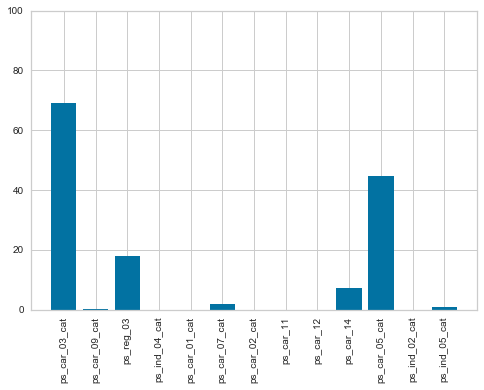

{'ps_car_01_cat': 0.01797678810239041,
 'ps_car_02_cat': 0.0008400368272145051,
 'ps_car_03_cat': 69.08983689844963,
 'ps_car_05_cat': 44.78253126617071,
 'ps_car_07_cat': 1.9302366215734896,
 'ps_car_09_cat': 0.09559619093701067,
 'ps_car_11': 0.0008400368272145051,
 'ps_car_12': 0.000168007365442901,
 'ps_car_14': 7.160473915176441,
 'ps_ind_02_cat': 0.036289590935666624,
 'ps_ind_04_cat': 0.013944611331760785,
 'ps_ind_05_cat': 0.975954785857812,
 'ps_reg_03': 18.106489788512327}

In [10]:
# As the dataset description mentioned -1 is the missing value
train = pd.read_csv("/Users/ivy/Desktop/CSC529 /Final Project/train.csv",na_values="-1")

# Plot the missing value percentages
missing_percentages(data)

In [3]:
# Print data shape
print "Dataset shape is:",train.shape
# Print total Null value
print "Null values:", train.isnull().sum().sum()
# Check duplicates
print "Duplicates are:",train.duplicated().sum()

Dataset shape is: (595212, 59)
Null values: 846458
Duplicates are: 0


# 1.4
## Check target value is balanced or not
- Extrac the feature we want to predict 
- plot distribution of our target feature
- Target feature is imbalanced and target 0 is expected be be high bias

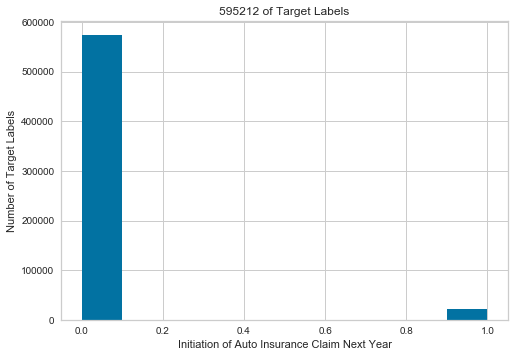

In [4]:
# Extract the feature that we want to predict, which is the Target feature in the data frame
target = train["target"]

#plot distribution of our target feature
plt.hist(target)
plt.title("595212 of Target Labels")
plt.xlabel('Initiation of Auto Insurance Claim Next Year')
plt.ylabel('Number of Target Labels')
plt.show()
# reweighted on data

In [7]:
# copy dataframe 
df = train.copy()
df1 = df.drop(['id'],axis=1)
#check the outliers and missing values
# min = -1 is obviously the missing value
stats = df1.describe().T

# 1.5
## Check the dataset correlation 
- Compute the correlation matrix
- Visualize the correlation matrix heatmap
- Correlation shows that from ps_calc_01 to ps_calc_19_bin don't have correlation with target at all
- Drop unnecessary columns to prevent the curse of dimensionality
- Compute the new correlation matrix after drop unnecessary features

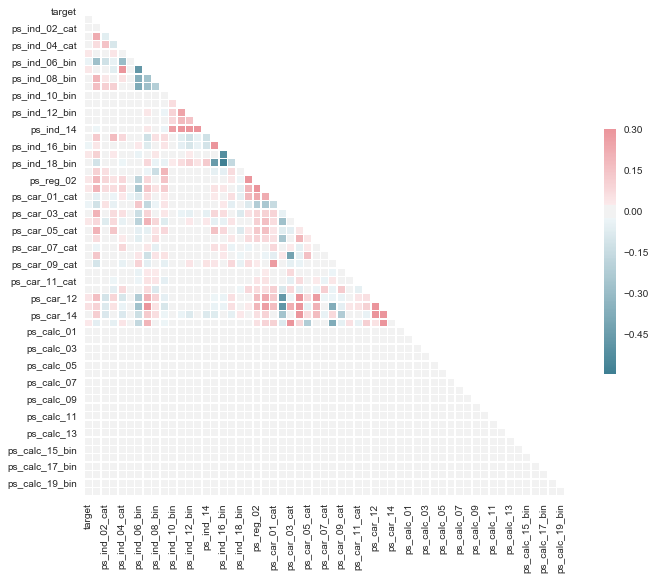

In [7]:
# Compute the correlation matrix
corr = df1.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [8]:
# Drop unnecessary columns to prevent the curse of dimensionality.
unnecessary = df1.columns[df1.columns.str.startswith('ps_calc_')]
# Transform to a new dataframe
df2 = df1.drop(unnecessary,axis=1)

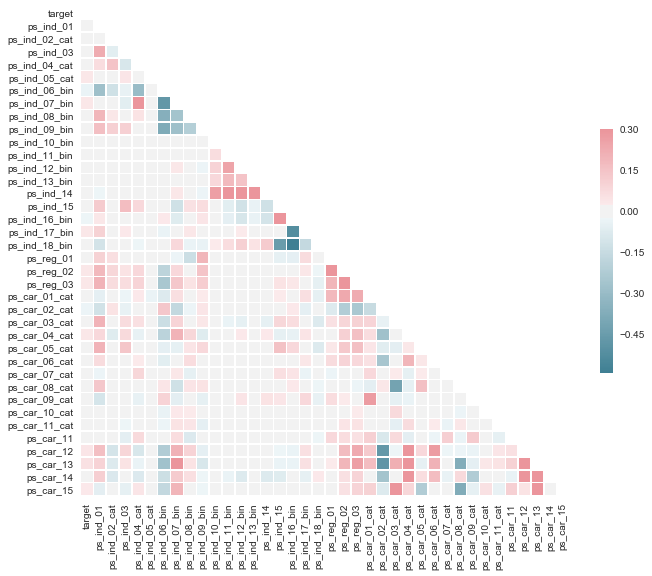

In [27]:
# Compute the correlation matrix
corr1 = df2.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the new correlation heatmap with the mask and correct aspect ratio
sns.heatmap(corr1, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# 1.6 
## Heatmap on the degree of nullity relationship between different features
- The range of this nullity correlation is from -1 to 1 (-1 ≤ R ≤ 1)
- Features with no missing value are excluded in the heatmap
- If the nullity correlation is very close to zero (-0.05 < R < 0.05), no value will be displayed
- A perfect positive nullity correlation (R=1) indicates when the first feature and the second feature both have corresponding missing values while a perfect negative nullity 
-  correlation (R=-1) means that one of the features is missing and the second is not missing.

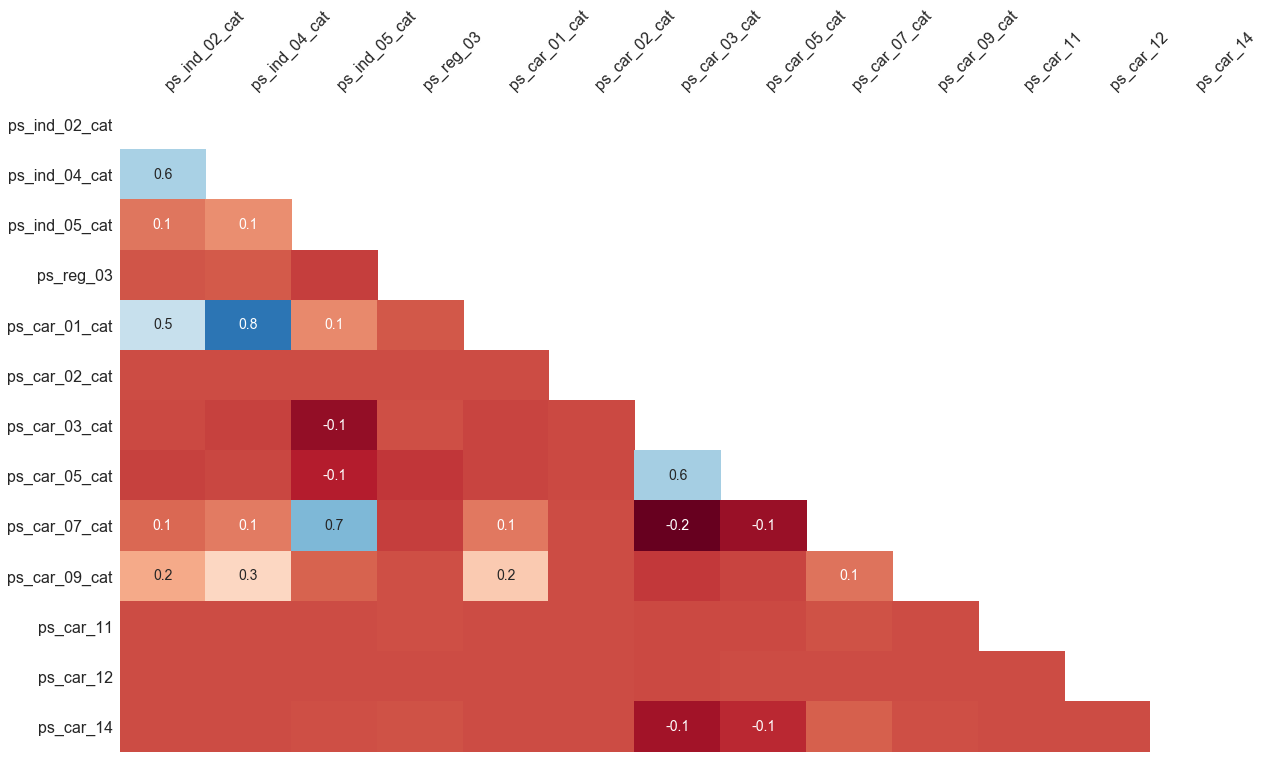

In [28]:
# Plot the heatmap
msno.heatmap(df2.sample(595212))

# 1.7
## Preprocessing dataset on removing duplicates and imputing missing values
- Remove duplicates
- Remove the features with the most missing values and correlation with target is 0
- Fill missing values with mode value on categorical variable and binary variable 
- Fill missing values with mean value on continuous or ordinal variables

In [9]:
# it shows the df2 has 5 duplicated rows, drop the duplicates
df2 = df2.drop_duplicates()
df2.duplicated().sum()

0

In [10]:
# The report shows that variable ps_car_03_cat and ps_car_05_cat have the most missing values,
# and their correlation with target is 0, so we can drop them
df3 = df2.drop(["ps_car_03_cat", "ps_car_05_cat"], axis=1)

In [57]:
# cat is categorical variable, and bin is binary variable, 
# so fill missing values with mode value
# all other are either continuous or ordinal variables, so fill with mean value
# put each of them in lists
cat_columns = list(filter(lambda x: x.endswith("cat"),
                                     df3.columns))
bin_columns = list(filter(lambda x: x.endswith("bin"),
                                     df3.columns))
conti_columns = list(filter(lambda x: x not in bin_columns + cat_columns,
                                     df3.columns))

for i in cat_columns:
    df3[i].fillna(value = df3[i].mode()[0],inplace=True)
for i in bin_columns:
    df3[i].fillna(value=df3[i].mode()[0],inplace=True)
for i in conti_columns:
    df3[i].fillna(value=df3[i].mean(),inplace=True)
    
print "Missing value after preprocessing is:",df3.isnull().sum().sum()
print "Shape of Dataset is:", df3.shape

Missing value after preprocessing is: 0
Shape of Dataset is: (595207, 36)


# 1.8
## Create dummy variables to convert the categorical variables

In [12]:
df4 = pd.get_dummies(df3, columns = cat_columns) 
df4 = df4.drop_duplicates()
print "After created dummies for categorical variables Dataset is:", df4.shape
# df4.to_csv("/Users/ivy/Desktop/csc478/Final Project/cleaned.csv")

After created dummies for categorical variables Dataset is: (595206, 195)


# 1.9 
## Split dataset on 65% training set and 35% testing set

In [58]:
# split X, y
X = df4.drop(['target'], axis=1)
y = df4["target"]

#randomly split dataset 35% for test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.35,random_state=10)

In [59]:
def evaluation(ytest, ypred):
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(ytest, ypred).ravel()
    recip_n = 100.0 / len(y_test)
    print '\nAccuracy score: %.3f' % accuracy_score(ytest,ypred)
    print '\tTrue positives rate: %.2f%%' % (tp * recip_n) 
    print '\tTrue negatives rate: %.2f%%' % (tn * recip_n) 
    print '\tFalse positives rate: %.2f%%' % (fp * recip_n) 
    print '\tFalse negatives rate: %.2f%%' % (fn * recip_n) 
    print 'F1 score: %.3f' % f1_score(ytest, ypred)
    print '\tPrecision score: %.3f' % precision_score(ytest, ypred)
    print '\tRecall score: %.3f' % recall_score(ytest, ypred)

# 2.0
## Evaluate model on raw dataset and visualize the performance
- Random Forest 
- Support Vector Machine

In [13]:
# raw dataset fit clf - Random Forest
clf = RandomForestClassifier(random_state = 15)
clf.fit(X_train,y_train)

clf_test_pred = clf.predict(X_test)
clf_train_pred = clf.predict(X_train)

print "Below is Raw Data train performance:", evaluation(y_train, clf_train_pred)
print "\n\nBelow is Raw Data test performance:", evaluation(y_test, clf_test_pred)

Below is Raw Data train performance: 
Accuracy score: 0.991
	True positives rate: 5.07%
	True negatives rate: 178.98%
	False positives rate: 0.00%
	False negatives rate: 1.67%
F1 score: 0.859
	Precision score: 1.000
	Recall score: 0.753
None


Below is Raw Data test performance: 
Accuracy score: 0.963
	True positives rate: 0.00%
	True negatives rate: 96.31%
	False positives rate: 0.01%
	False negatives rate: 3.68%
F1 score: 0.001
	Precision score: 0.143
	Recall score: 0.000
None


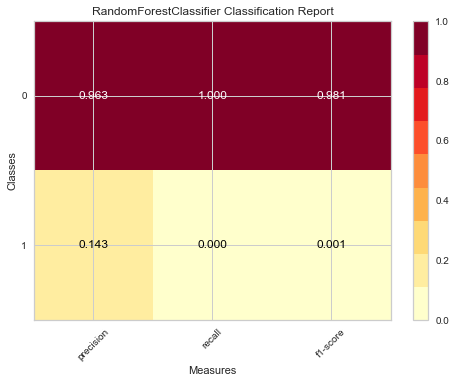

In [14]:
# The classification report visualizer displays the precision, recall, and F1 scores for the model.
# classification report on raw data
classes = ['0', '1']
visualizer = ClassificationReport(clf,classes=classes)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof() 

In [ ]:
# Tuning the hyper-parameters using GridSearch
C_range = 10. ** np.arange(-3, 4)
gamma_range = 10. ** np.arange(-3, 4)
#kernels = ['linear','poly', 'rbf', 'sigmoid']
#kernel = kernels,
param_grid = dict(gamma = gamma_range, C = C_range)

grid = GridSearchCV(SVC(), param_grid=param_grid, cv=StratifiedKFold(y=y_train, n_folds = 5))

grid.fit(X_train, y_train)

print("The best classifier is: ", grid.best_estimator_)

In [ ]:
model = grid.best_estimator_
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# 2.1
## Balanced dataset
- Balanced dataset using Undersampling method
- GridSearch find the best parameters

In [75]:
# Undersampling data make it balanced
under = RandomUnderSampler(return_indices=True)
X_resampled, y_resampled, idx_resampled = under.fit_sample(X_train, y_train)
print("After Under Sampling, counts of label '1': {}".format(sum(y_resampled==1)))
print("After Under Sampling, counts of label '0': {}".format(sum(y_resampled==0)))


After Under Sampling, counts of label '1': 14025
After Under Sampling, counts of label '0': 14025


In [28]:
# clf1 - Random Forest on undersampling balanced data
clf1 = RandomForestClassifier(random_state = 15)
clf1.fit(X_resampled,y_resampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=15, verbose=0, warm_start=False)

In [30]:
param_grid = {"max_depth": [3, 5,10,15],
              "max_features": [2, 3, 10,20],
              "min_samples_split": [2, 3, 10,20],
              "min_samples_leaf": [2, 3, 10,20],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search1 = GridSearchCV(clf1, param_grid=param_grid)
grid_search1.fit(X_resampled, y_resampled)
print("The best classifier is: ", grid_search1.best_estimator_)

('The best classifier is: ', RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=10, max_features=20, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=15, verbose=0, warm_start=False))


In [31]:
model1 = grid_search1.best_estimator_
model1.fit(X_resampled,y_resampled)

model1_test_pred = model1.predict(X_test)
model1_train_pred = model1.predict(X_resampled)

print "Evaluation on Trainging:", evaluation(y_resampled,model1_train_pred)
print "\nEvalueation on Testing:", evaluation(y_test,model1_test_pred)

Evaluation on Trainging: 
Accuracy score: 0.655
	True positives rate: 4.20%
	True negatives rate: 4.62%
	False positives rate: 2.11%
	False negatives rate: 2.53%
F1 score: 0.644
	Precision score: 0.666
	Recall score: 0.624
None

Evalueation on Testing: 
Accuracy score: 0.610
	True positives rate: 2.05%
	True negatives rate: 58.93%
	False positives rate: 37.39%
	False negatives rate: 1.63%
F1 score: 0.095
	Precision score: 0.052
	Recall score: 0.558
None


In [ ]:
model_svm = grid_svm.best_estimator_
model_svm.fit(X_resampled,y_resampled)

model_svm_test_pred = model_svm.predict(X_test)
model_svm_train_pred = model_svm.predict(X_resampled)

print "Evaluation on Trainging:", evaluation(y_resampled,model_svm_train_pred)
print "\nEvalueation on Testing:", evaluation(y_test,model_svm_test_pred)

In [ ]:
# RBF kernel
# set cost and gamma range
gamma_range=['0.001','0.01','0.1','1.0','10.0']
C_range=['0.01','0.1','10.0','100.0'] 
# plot 
colnames=['Cost']
colnames.extend(gamma_range)

compare_DF = pd.DataFrame(columns=colnames)
err_records = []

method = 'Holdout (test=0.35)'

for c in C_range:
   compare_row = [c]
   for g in gamma_range:
       svm = SVC(kernel='rbf', gamma=float(g), C=float(c))
       svm.fit(X_resampled, y_resampled)     
       score = svm.score(X_test, y_test)
       compare_row.extend([1-score])
   err_records.append(compare_row)
   
compare_DF = pd.DataFrame(err_records, columns=colnames)

In [18]:
svm_model = SVC(kernel='rbf', C=10.0, gamma=0.01)
svm_model.fit(X_resampled, y_resampled)
svm_y_test_pred = svm_model.predict(X_test)
svm_y_train_pred = svm_model.predict(X_resampled)

In [ ]:
print "Evaluation on Trainging:", evaluation(y_resampled,svm_y_train_pred)
print "\nEvalueation on Testing:", evaluation(y_test,svm_y_test_pred)

Evaluation on Trainging: 
Accuracy score: 0.651
	True positives rate: 4.17%
	True negatives rate: 4.60%
	False positives rate: 2.13%
	False negatives rate: 2.57%
F1 score: 0.639
	Precision score: 0.661
	Recall score: 0.619
None

Evalueation on Testing: 
Accuracy score: 0.624
	True positives rate: 2.02%
	True negatives rate: 60.36%
	False positives rate: 35.96%
	False negatives rate: 1.66%
F1 score: 0.097
	Precision score: 0.053
	Recall score: 0.548
None


In [ ]:
# The classification report visualizer displays the precision, recall, and F1 scores for the model.
# classification report on balanced and normalized data
classes = ['0', '1']
visualizer = ClassificationReport(svm_model,classes=classes)
visualizer.fit(X_resampled, y_resampled)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

# 2.2
## Normalization on balanced (Undersampling) dataset
- Evaluate the transformed data: normalized and balanced dataset
- Random Forest with best parameters after GridSearch 

In [76]:
# normalized the data with undersampling method
scaler = StandardScaler()
scaler.fit(X_resampled)
X_train1 = scaler.transform(X_resampled)
X_test1 = scaler.transform(X_test)

In [33]:
print len(X_train1),len(X_test1),

28050 208323


In [600]:
# clf2 - Random Forest on undersampling balanced data
clf2 = RandomForestClassifier(random_state = 15)
clf2.fit(X_train1,y_resampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=15, verbose=0, warm_start=False)

In [601]:
param_grid = {"max_depth": [3, 5,10,15],
              "max_features": [2, 3, 10,20],
              "min_samples_split": [2, 3, 10,20],
              "min_samples_leaf": [2, 3, 10,20],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search2 = GridSearchCV(clf2, param_grid=param_grid)
grid_search2.fit(X_train1, y_resampled)
print("The best classifier is: ", grid_search2.best_estimator_)

('The best classifier is: ', RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=10, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=15, verbose=0, warm_start=False))


In [77]:
model2 = grid_search1.best_estimator_
model2.fit(X_train1,y_resampled)

model2_test_pred = model2.predict(X_test1)
model2_train_pred = model2.predict(X_train1)

print "Evaluation on Trainging:", evaluation(y_resampled,model2_train_pred)
print "\nEvalueation on Testing:", evaluation(y_test,model2_test_pred)

Evaluation on Trainging: 
Accuracy score: 0.659
	True positives rate: 4.33%
	True negatives rate: 4.55%
	False positives rate: 2.18%
	False negatives rate: 2.41%
F1 score: 0.653
	Precision score: 0.665
	Recall score: 0.642
None

Evalueation on Testing: 
Accuracy score: 0.600
	True positives rate: 2.07%
	True negatives rate: 57.89%
	False positives rate: 38.43%
	False negatives rate: 1.61%
F1 score: 0.094
	Precision score: 0.051
	Recall score: 0.562
None


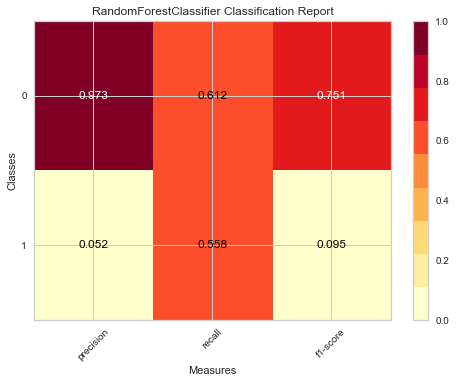

In [35]:
# The classification report visualizer displays the precision, recall, and F1 scores for the model.
# classification report on balanced and normalized data
classes = ['0', '1']
visualizer = ClassificationReport(model2,classes=classes)
visualizer.fit(X_train1, y_resampled)  # Fit the training data to the visualizer
visualizer.score(X_test1, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

In [36]:
predictions_proba = model2.predict_proba(X_test1)

log_loss_score = log_loss(y_test, predictions_proba)

acc = accuracy_score(y_test, model2_test_pred)
f1 = f1_score(y_test, model2_test_pred)
print('Log loss: %.5f' % log_loss_score)  # 0.66921

Log loss: 0.66964


In [18]:
svm_model1 = SVC(kernel='rbf', C=10.0, gamma=0.01)
svm_model1.fit(X_train1, y_resampled)
svm_y_test_pred1 = svm_model1.predict(X_test1)
svm_y_train_pred1 = svm_model1.predict(X_train1)

In [19]:
print "Evaluation on Trainging:", evaluation(y_resampled,svm_y_train_pred1)
print "\nEvalueation on Testing:", evaluation(y_test,svm_y_test_pred1)

Evaluation on Trainging: 
Accuracy score: 0.883
	True positives rate: 5.68%
	True negatives rate: 6.21%
	False positives rate: 0.52%
	False negatives rate: 1.05%
F1 score: 0.878
	Precision score: 0.916
	Recall score: 0.844
None

Evalueation on Testing: 
Accuracy score: 0.585
	True positives rate: 1.89%
	True negatives rate: 56.59%
	False positives rate: 39.73%
	False negatives rate: 1.79%
F1 score: 0.083
	Precision score: 0.045
	Recall score: 0.512
None


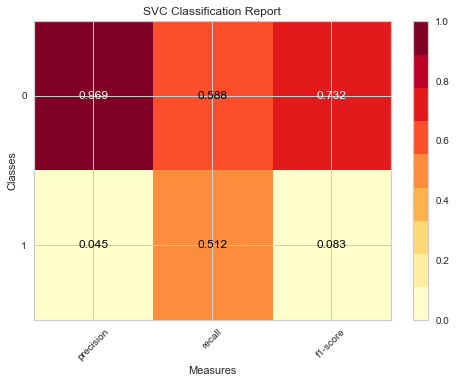

In [27]:
# The classification report visualizer displays the precision, recall, and F1 scores for the model.
# classification report on balanced and normalized data
classes = ['0', '1']
visualizer = ClassificationReport(svm_model1,classes=classes)
visualizer.fit(X_train1, y_resampled)  # Fit the training data to the visualizer
visualizer.score(X_test1, y_test)  # Evaluate the model on the test data
g = visualizer.poof()   

# 2.3
## Feature selection
- feature selection on feature importances
- Visualize the top 10 important features

In [62]:
X_train1.shape[1]

194

In [78]:
feature_list = X_train.columns.values
# Get numerical feature importances
importances = list(model2.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
for pair in feature_importances[:10]:
    print'Variable: {:20} Importance: {}'.format(*pair) 

Variable: ps_car_13            Importance: 0.1395
Variable: ps_reg_03            Importance: 0.0779
Variable: ps_reg_02            Importance: 0.0628
Variable: ps_ind_05_cat_0.0    Importance: 0.0472
Variable: ps_car_14            Importance: 0.0436
Variable: ps_ind_15            Importance: 0.0421
Variable: ps_car_04_cat_0      Importance: 0.0395
Variable: ps_ind_17_bin        Importance: 0.0389
Variable: ps_car_15            Importance: 0.0373
Variable: ps_ind_03            Importance: 0.037


In [65]:
d = dict(feature_importances)
lists = sorted(d.items(),reverse=True)[:15] # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
y1 = list(y)
#sorted(d.values(),reverse=True)

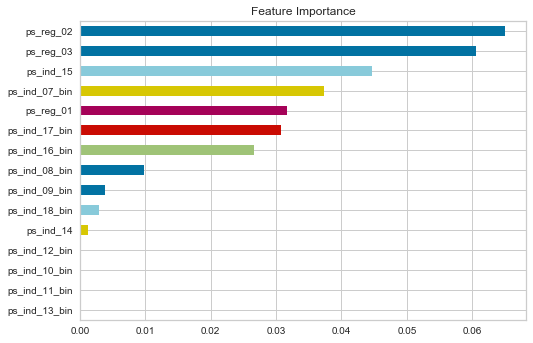

In [43]:
pd.Series(y, x).sort_values(ascending=True).plot.barh(title="Feature Importance")
plt.figure(figsize = (30,40))

In [79]:
# Store X_train1 value in a dataframe for future model analysis
x_train_df = pd.DataFrame(X_train1,columns=X.columns)
x_test_df = pd.DataFrame(X_test1,columns=X.columns)

In [80]:
# Extract 10 most important features
x_train_df_features = x_train_df[['ps_car_13','ps_reg_02','ps_reg_03','ps_car_14','ps_ind_03',
                                  'ps_ind_15','ps_ind_07_bin','ps_car_04_cat_0','ps_ind_05_cat_0.0','ps_reg_01']]
x_test_df_features = x_test_df[['ps_car_13','ps_reg_02','ps_reg_03','ps_car_14','ps_ind_03',
                                'ps_ind_15','ps_ind_07_bin','ps_car_04_cat_0','ps_ind_05_cat_0.0','ps_reg_01']]

In [85]:
# Fit RF model on new features
model2 = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=10, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=15, verbose=0, warm_start=False)

model2.fit(x_train_df_features,y_resampled)
important_test_pred = model2.predict(x_test_df_features)
important_train_pred = model2.predict(x_train_df_features)

print "Selected Features on Train Performance:"
print evaluation(y_resampled, important_train_pred)
print "\nSelected Features on Test Performance:"
print evaluation(y_test, important_test_pred)

Selected Features on Train Performance:

Accuracy score: 0.630
	True positives rate: 3.77%
	True negatives rate: 4.72%
	False positives rate: 2.02%
	False negatives rate: 2.96%
F1 score: 0.602
	Precision score: 0.652
	Recall score: 0.560
None

Selected Features on Test Performance:

Accuracy score: 0.622
	True positives rate: 1.77%
	True negatives rate: 60.40%
	False positives rate: 35.92%
	False negatives rate: 1.91%
F1 score: 0.086
	Precision score: 0.047
	Recall score: 0.480
None


In [86]:
predictions_proba1 = model2.predict_proba(x_test_df_features)

log_loss_score = log_loss(y_test, predictions_proba1)

acc = accuracy_score(y_test, important_test_pred)
f1 = f1_score(y_test, important_test_pred)
print('Log loss: %.5f' % log_loss_score)  # 0.66921

Log loss: 1.46424


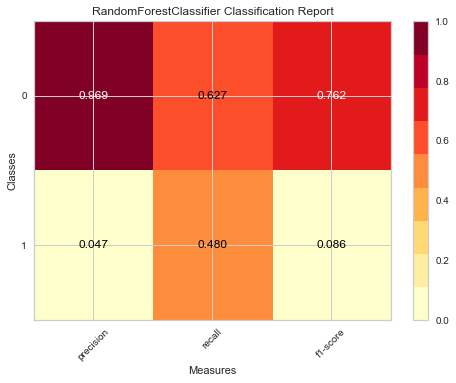

In [87]:
# The classification report visualizer displays the precision, recall, and F1 scores for the model.
# classification report on balanced and normalized data
classes = ['0', '1']
visualizer = ClassificationReport(model2,classes=classes)
visualizer.fit(x_train_df_features, y_resampled)  # Fit the training data to the visualizer
visualizer.score(x_test_df_features, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data